In [1]:
from config import api_key
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = f'https://api.census.gov/data/2018/abscbo?get=GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,OWNER_SEX,OWNER_SEX_LABEL,OWNER_ETH,OWNER_ETH_LABEL,OWNER_RACE,OWNER_RACE_LABEL,OWNER_VET,OWNER_VET_LABEL,QDESC,QDESC_LABEL,OWNCHAR,OWNCHAR_LABEL,OWNPDEMP,OWNPDEMP_PCT&for=state:*&key={api_key}'
res = requests.get(url).json()

In [3]:
bo_df = pd.DataFrame(res)
bo_df.columns = bo_df.iloc[0]
bo_df.drop(bo_df.index[0], inplace=True)
bo_df = bo_df.reset_index()
bo_df.drop(['index'], axis=1, inplace=True)

In [4]:
url = f'https://api.census.gov/data/2018/abstcb?get=GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,NSFSZFI,NSFSZFI_LABEL,FACTORS_P,FACTORS_P_LABEL,FACTORS_U,FACTORS_U_LABEL,IMPACTWF_P,IMPACTWF_P_LABEL,'+ \
f'IMPACTWF_U,IMPACTWF_U_LABEL,IMPACTWK_P,IMPACTWK_P_LABEL,IMPACTWK_U,IMPACTWK_U_LABEL,MOTPRODTECH,MOTPRODTECH_LABEL,MOTUSETECH,MOTUSETECH_LABEL,TECHSELL,TECHSELL_LABEL,TECHUSE,TECHUSE_LABEL&for=us:*&key={api_key}'
res = requests.get(url).json()
tech_df = pd.DataFrame(res)
tech_df.columns = tech_df.iloc[0]
tech_df.drop(tech_df.index[0], inplace=True)
#tech_df

In [62]:
#Balance of work and family by state and by gender. indexes, 6, 7, 8 Top 10?
questionFocus = bo_df.loc[bo_df['QDESC_LABEL'] == 'REASONOWN']
questionFocusVery = questionFocus.loc[questionFocus['OWNCHAR_LABEL'] == 'Balance work and family: Very important'].copy()
questionFocusSome = questionFocus.loc[questionFocus['OWNCHAR_LABEL'] == 'Balance work and family: Somewhat important'].copy()
questionFocusNot = questionFocus.loc[questionFocus['OWNCHAR_LABEL'] == 'Balance work and family: Not important'].copy()


from cProfile import label
from msilib.schema import tables
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json') as response:
    stateBoxes = json.load(response)

import plotly.graph_objects as go

def dropUnnecessary(dataF):
    dataF = dataF.drop(['GEO_ID','NAICS2017','NAICS2017_LABEL','OWNER_SEX','OWNER_SEX_LABEL','OWNER_ETH','OWNER_ETH_LABEL',
    'OWNER_RACE','OWNER_RACE_LABEL','OWNER_VET','OWNER_VET_LABEL','QDESC','QDESC_LABEL','OWNCHAR'], axis=1).copy()
    return dataF

questionFocusVery.sort_values(by=['state'], inplace= True)
questionFocusSome.sort_values(by=['state'], inplace= True)
questionFocusNot.sort_values(by=['state'], inplace= True)
questionFocusVery = dropUnnecessary(questionFocusVery)
questionFocusSome = dropUnnecessary(questionFocusSome)
questionFocusNot = dropUnnecessary(questionFocusNot)
questionFocusVery.rename(columns={'OWNPDEMP':"VeryResponses", 'OWNPDEMP_PCT':'VeryResponsesPct'}, inplace=True)
questionFocusSome.rename(columns={'OWNPDEMP':"SomewhatResponses", 'OWNPDEMP_PCT':'SomewhatResponsesPct'}, inplace=True)
questionFocusNot.rename(columns={'OWNPDEMP':"NotResponses", 'OWNPDEMP_PCT':'NotResponsesPct'}, inplace=True)

tablesMerged = questionFocusVery.merge(questionFocusSome, how='inner', on='state')
tablesMerged.drop(['NAME_y', 'OWNCHAR_LABEL_y'], axis=1, inplace=True)
lifeWorkBalance = tablesMerged.merge(questionFocusNot, how='inner', on='state')
lifeWorkBalance.drop(['NAME', 'OWNCHAR_LABEL', 'OWNCHAR_LABEL_x'], axis=1, inplace=True)
lifeWorkBalance.rename(columns={'NAME_x':'StateName'}, inplace=True)
lifeWorkBalance = lifeWorkBalance.astype({'VeryResponsesPct': 'float'})
#print(lifeWorkBalance.dtypes)

fig = go.Figure(go.Choroplethmapbox(geojson=stateBoxes, locations = lifeWorkBalance.state, z = lifeWorkBalance.VeryResponsesPct, colorbar_title = "Percent", colorscale = 'Viridis', zmin = 40, zmax = 65, marker_opacity = 0.5, marker_line_width = 0))
fig.update_layout(title_text = '2019 Business Owners Who Value Family and Work Balance by Percent', geo = dict(scope = 'usa', projection = go.layout.geo.Projection(type='albers usa'), showlakes=True),mapbox_style="carto-positron",
                  mapbox_zoom=3, mapbox_center = {"lat": 37.0902, "lon": -95.7129}, margin={"r":0,"t":35,"l":0,"b":0})

fig.show()

In [40]:
bottomFive = lifeWorkBalance.sort_values('VeryResponsesPct').head()
topFive = lifeWorkBalance.sort_values('VeryResponsesPct', ascending=False).head()

,StateName,VeryResponses,VeryResponsesPct,state,SomewhatResponses,SomewhatResponsesPct,NotResponses,NotResponsesPct
44,Utah,30041,62.9,49,13071,27.4,4555,9.5
9,Florida,184150,60.8,12,79384,26.2,36831,12.2
28,Nevada,18214,60.5,32,7693,25.6,4054,13.5
2,Arizona,43958,59.1,04,19966,26.8,9885,13.3
10,Georgia,67013,58.9,13,31103,27.3,14602,12.8


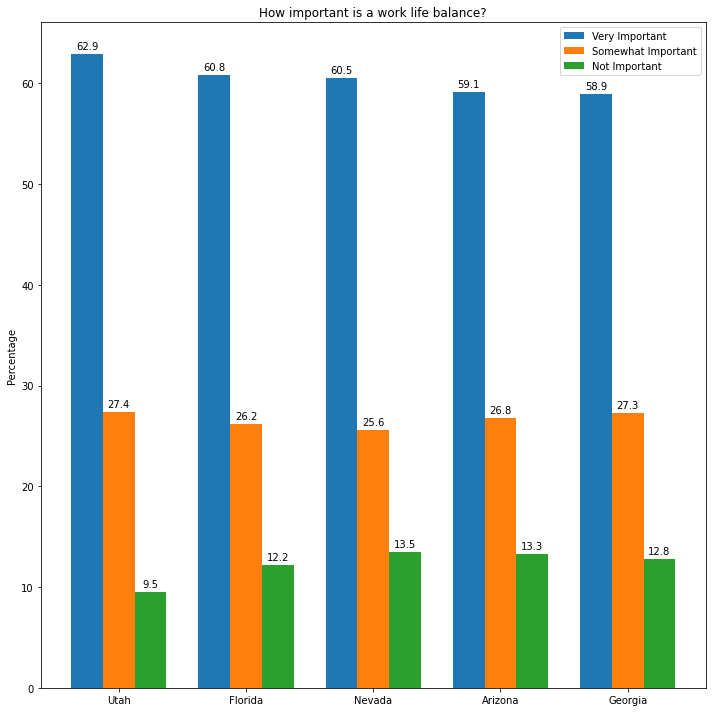

In [66]:
topFive_statenames = topFive['StateName']
topFive_veryVals = topFive['VeryResponsesPct'].astype(float)
topFive_someVals = topFive['SomewhatResponsesPct'].astype(float)
topFive_notVals = topFive['NotResponsesPct'].astype(float)

import numpy as np
import matplotlib.pyplot

x = np.arange(len(topFive_statenames))
width = 0.25

fig, ax = plt.subplots()
rect_1 = ax.bar(x - width, topFive_veryVals, width, label= 'Very Important')
rect_2 = ax.bar(x,  topFive_someVals, width, label = 'Somewhat Important')
rect_3 = ax.bar(x + width, topFive_notVals, width, label='Not Important')

ax.set_ylabel('Percentage')
ax.set_title('How important is a work life balance?')
ax.set_xticks(x, topFive_statenames)
ax.legend()

ax.bar_label(rect_1, padding=3)
ax.bar_label(rect_2, padding=3)
ax.bar_label(rect_3, padding=3)
fig.set_size_inches(10, 10)
fig.tight_layout()
plt.savefig('TopFive.png')
plt.show()

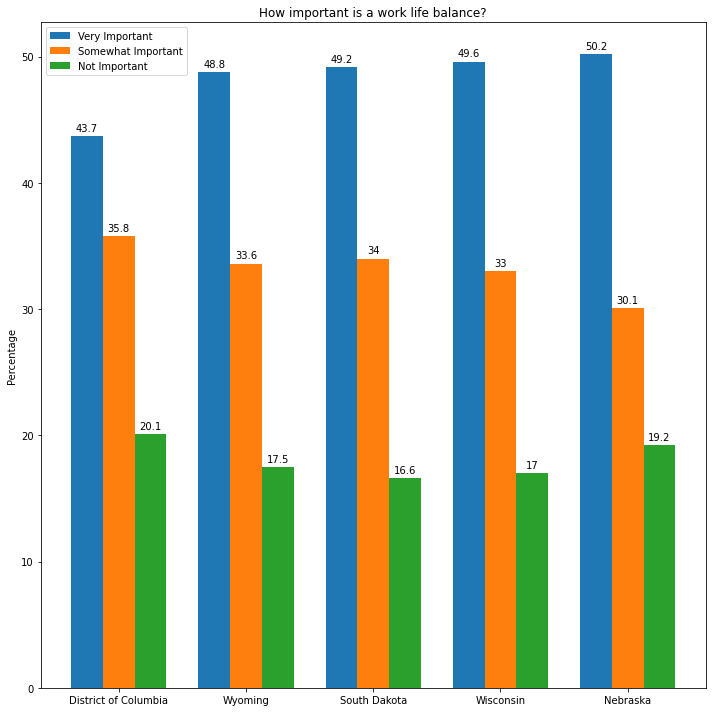

In [65]:
bottomFive_statenames = bottomFive['StateName']
bottomFive_veryVals = bottomFive['VeryResponsesPct'].astype(float)
bottomFive_someVals = bottomFive['SomewhatResponsesPct'].astype(float)
bottomFive_notVals = bottomFive['NotResponsesPct'].astype(float)

import numpy as np
import matplotlib.pyplot

x = np.arange(len(topFive_statenames))
width = 0.25

fig, ax = plt.subplots()
rect_1 = ax.bar(x - width, bottomFive_veryVals, width, label= 'Very Important')
rect_2 = ax.bar(x,  bottomFive_someVals, width, label = 'Somewhat Important')
rect_3 = ax.bar(x + width, bottomFive_notVals, width, label='Not Important')

ax.set_ylabel('Percentage')
ax.set_title('How important is a work life balance?')
ax.set_xticks(x, bottomFive_statenames)
ax.legend()

ax.bar_label(rect_1, padding=3)
ax.bar_label(rect_2, padding=3)
ax.bar_label(rect_3, padding=3)
fig.set_size_inches(10, 10)
fig.tight_layout()
plt.savefig('BottomFive.png')
plt.show()


In [61]:
url = f'https://api.census.gov/data/2018/abscbo?get=GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,OWNER_SEX,OWNER_SEX_LABEL,OWNER_ETH,OWNER_ETH_LABEL,OWNER_RACE,OWNER_RACE_LABEL,OWNER_VET,OWNER_VET_LABEL,QDESC,QDESC_LABEL,OWNCHAR,OWNCHAR_LABEL,OWNPDEMP,OWNPDEMP_PCT&for=state:*&key={api_key}'
res = requests.get(url).json()

age_df = pd.DataFrame(res)
age_df.columns = age_df.iloc[0]
age_df.drop(age_df.index[0], inplace=True)
age_df = age_df.reset_index()
age_df.drop(['index'], axis=1, inplace=True)

age_df

,GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,OWNER_SEX,OWNER_SEX_LABEL,OWNER_ETH,OWNER_ETH_LABEL,OWNER_RACE,OWNER_RACE_LABEL,OWNER_VET,OWNER_VET_LABEL,QDESC,QDESC_LABEL,OWNCHAR,OWNCHAR_LABEL,OWNPDEMP,OWNPDEMP_PCT,state
0,0400000US28,Mississippi,00,Total for all sectors,001,All owners of respondent firms,001,All owners of respondent firms,00,All owners of respondent firms,001,All owners of respondent firms,O02,YRACQBUS,CG,Before 1980,1158,4.6,28
1,0400000US28,Mississippi,00,Total for all sectors,001,All owners of respondent firms,001,All owners of respondent firms,00,All owners of respondent firms,001,All owners of respondent firms,O02,YRACQBUS,CH,1980 to 1989,1978,7.8,28
2,0400000US28,Mississippi,00,Total for all sectors,001,All owners of respondent firms,001,All owners of respondent firms,00,All owners of respondent firms,001,All owners of respondent firms,O02,YRACQBUS,CI,1990 to 1999,2983,11.8,28
3,0400000US28,Mississippi,00,Total for all sectors,001,All owners of respondent firms,001,All owners of respondent firms,00,All owners of respondent firms,001,All owners of respondent firms,O02,YRACQBUS,CI01,2000 to 2007,5251,20.8,28
4,0400000US28,Mississippi,00,Total for all sectors,001,All owners of respondent firms,001,All owners of respondent firms,00,All owners of respondent firms,001,All owners of respondent firms,O02,YRACQBUS,CI02,2008 to 2012,3727,14.8,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5924,0400000US27,Minnesota,00,Total for all sectors,001,All owners of respondent firms,001,All owners of respondent firms,00,All owners of respondent firms,001,All owners of respondent firms,O15,PRIORBUSTAT,DI3,Business was purchased by another company,573,0.6,27
5925,0400000US27,Minnesota,00,Total for all sectors,001,All owners of respondent firms,001,All owners of respondent firms,00,All owners of respondent firms,001,All owners of respondent firms,O15,PRIORBUSTAT,DI4,Business was purchased by another individual,872,1.0,27
5926,0400000US27,Minnesota,00,Total for all sectors,001,All owners of respondent firms,001,All owners of respondent firms,00,All owners of respondent firms,001,All owners of respondent firms,O15,PRIORBUSTAT,DI5,Other,3020,3.3,27
5927,0400000US27,Minnesota,00,Total for all sectors,001,All owners of respondent firms,001,All owners of respondent firms,00,All owners of respondent firms,001,All owners of respondent firms,O15,PRIORBUSTAT,DITR,Total reporting,90669,100.0,27
